#**DEEP LEARNING Modeling**

###**ROBERTA**

In [1]:
# Importing necessary libraries

!pip install ktrain
!pip install transformers

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timeit

pd.set_option('display.max_columns', None)
warnings.simplefilter(action="ignore")

import seaborn as sns
plt.style.use('seaborn')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 44.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319738 sha256=a7d5c859d41f9588d9c0d466c3ee31984606271136adba9cab58befaeabe5987
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 15 18:25:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W /  70W |   1529MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.__version__

'2.14.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Design Project"

/content/drive/My Drive/Design Project


In [4]:
train_data = pd.read_csv('preprocessed_train_data.csv')
test_data = pd.read_csv('preprocessed_test_data.csv')
valid_data = pd.read_csv('preprocessed_valid_data.csv')

In [5]:
# Selecting the features and target variables
X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [6]:
y_train.unique()

array([-1,  1])

In [7]:
# Recode class labels to 0 and 1

y_train = y_train.map({-1: 0, 1: 1})
y_test = y_test.map({-1: 0, 1: 1})

**Instantiating a RoBERTa Instance:**
- Creating a RoBERTa instance with the model name, max token length, the labels to be used for each category and the batch size.

In [8]:
class_label_names = ['Non-Propagandistic', 'Propagandistic']


roberta_transformer = text.Transformer('roberta-base', maxlen=512, classes=class_label_names, batch_size=16)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
### Data Preprocessing:

roberta_train = roberta_transformer.preprocess_train(X_train.to_list(), y_train.to_list())
roberta_val = roberta_transformer.preprocess_test(X_test.to_list(), y_test.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 334
	95percentile : 778
	99percentile : 1293


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 333
	95percentile : 787
	99percentile : 1320


**Compiling RoBERTa in a K-Train Learner Object:**
- Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [10]:
roberta_model = roberta_transformer.get_classifier()

In [11]:
roberta_learner_ins = ktrain.get_learner(model=roberta_model,
                            train_data=roberta_train,
                            val_data=roberta_val,
                            batch_size=10)

###**RoBERTa Model Details:**

In [12]:
roberta_learner_ins.model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Finding the Optimal Learning Rate for RoBERTa:**
- This is an optional step just to show how the learning rate can be found for any transformer model. Generally for Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2878/2878 [==============================] - 3384s 1s/step - loss: 0.2880 - accuracy: 0.8625
Epoch 2/3
2878/2878 [==============================] - 3351s 1s/step - loss: 0.5781 - accuracy: 0.8686
Epoch 3/3
2878/2878 [==============================] - 75s 26ms/step - loss: 1.9094 - accuracy: 0.7960


done.
Visually inspect loss plot and select learning rate associated with falling loss


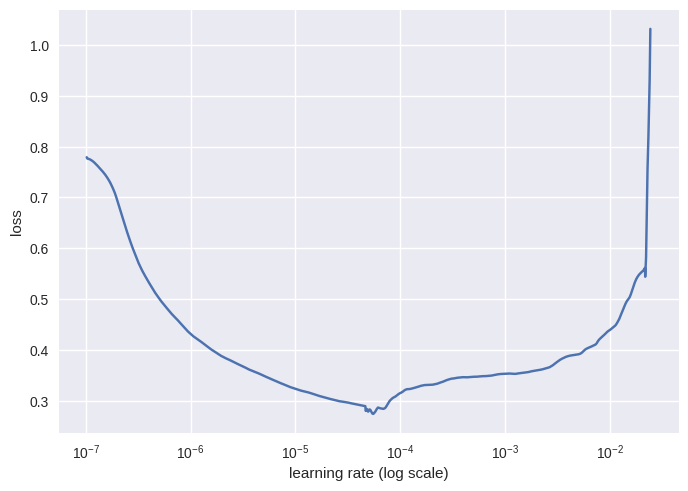


Total time in minutes on estimating optimal learning rate: 
 113.8586233978


In [ ]:
rate_finder_start_time = timeit.default_timer()
roberta_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

**RoBERTa Optimal Learning Rates:**
- As per the evaluations made in the research paper "RoBERTa: A Robustly Optimized BERT Pretraining Approach", below are the best choices in terms of fine-tuning the model:

- Batch Sizes => {16, 32}
- Learning Rates => {1e−5, 2e−5, 3e−5}

We will choose the maximum among these for our fine-tuning and evaluation purposes.

**Fine Tuning RoBERTa on Proppy Dataset:**
- Here we take our dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [13]:
from sklearn.utils import class_weight


# Get class weights from training data
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes =np.unique(y_train), y= y_train)

# Create a dictionary to map class index to weight
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 0.5629032888819365, 1: 4.4743549891202985}


In [14]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins.fit_onecycle(lr=3e-5, epochs=5, class_weight=class_weights_dict)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/5
2879/2879 [==============================] - 3904s 1s/step - loss: 0.3183 - accuracy: 0.8645 - val_loss: 0.2004 - val_accuracy: 0.9303
Epoch 2/5
2879/2879 [==============================] - 3825s 1s/step - loss: 0.2031 - accuracy: 0.9285 - val_loss: 0.1793 - val_accuracy: 0.9405
Epoch 3/5
2879/2879 [==============================] - 3850s 1s/step - loss: 0.2008 - accuracy: 0.9243 - val_loss: 0.1590 - val_accuracy: 0.9448
Epoch 4/5
2879/2879 [==============================] - 3870s 1s/step - loss: 0.1359 - accuracy: 0.9470 - val_loss: 0.1176 - val_accuracy: 0.9468
Epoch 5/5
2879/2879 [==============================] - 3869s 1s/step - loss: 0.0671 - accuracy: 0.9760 - val_loss: 0.1331 - val_accuracy: 0.9619

Total time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: 
 322.71115328435


##**Checking RoBERTa performance metrics:**

In [15]:
roberta_learner_ins.validate()

225/225 [==============================] - 308s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6394
           1       0.80      0.89      0.84       804

    accuracy                           0.96      7198
   macro avg       0.89      0.93      0.91      7198
weighted avg       0.96      0.96      0.96      7198



array([[6212,  182],
       [  92,  712]])

In [16]:
roberta_learner_ins.validate(class_names=class_label_names)

225/225 [==============================] - 304s 1s/step
                    precision    recall  f1-score   support

Non-Propagandistic       0.99      0.97      0.98      6394
    Propagandistic       0.80      0.89      0.84       804

          accuracy                           0.96      7198
         macro avg       0.89      0.93      0.91      7198
      weighted avg       0.96      0.96      0.96      7198



array([[6212,  182],
       [  92,  712]])

In [17]:
# Performance on Validation data

X_val = valid_data.text_preprocessed
y_val = valid_data.propaganda_label

# Recode class labels to 0 and 1
y_val = y_val.map({-1: 0, 1: 1})

roberta_val = roberta_transformer.preprocess_test(X_val.to_list(), y_val.to_list())

preprocessing test...
language: en
test sequence lengths:
	mean : 351
	95percentile : 825
	99percentile : 1353


In [18]:
roberta_learner_ins.validate(val_data=roberta_val, class_names=class_label_names)

5125/5125 [==============================] - 297s 58ms/step
                    precision    recall  f1-score   support

Non-Propagandistic       0.99      0.97      0.98      4550
    Propagandistic       0.77      0.91      0.84       575

          accuracy                           0.96      5125
         macro avg       0.88      0.94      0.91      5125
      weighted avg       0.96      0.96      0.96      5125



array([[4398,  152],
       [  53,  522]])

In [19]:
# Performance on test data

X_test_data = test_data.text_preprocessed
y_test_data = test_data.propaganda_label

# Recode class labels to 0 and 1
y_test_data = y_test_data.map({-1: 0, 1: 1})

roberta_test_data = roberta_transformer.preprocess_test(X_test_data.to_list(), y_test_data.to_list())

preprocessing test...
language: en
test sequence lengths:
	mean : 356
	95percentile : 847
	99percentile : 1410


In [20]:
roberta_learner_ins.validate(val_data=roberta_test_data, class_names=class_label_names)

10159/10159 [==============================] - 589s 58ms/step
                    precision    recall  f1-score   support

Non-Propagandistic       0.98      0.97      0.98      9019
    Propagandistic       0.79      0.88      0.83      1140

          accuracy                           0.96     10159
         macro avg       0.89      0.93      0.91     10159
      weighted avg       0.96      0.96      0.96     10159



array([[8755,  264],
       [ 135, 1005]])